In [1]:
%matplotlib ipympl
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Model of the ALP field.

* Amplitude follows a Rayleigh distribution.
* Frequency follows a normal distribution (leading to decoherence of the field, important for low-frequency fluctuations).
* Phase follows a uniform distribution.

In [224]:
Q_factor = 1e3  # smaller Q factor than 1e6 for faster simulations
freq = 1e3
sample_freq = 1e4
sample_time = 1 / sample_freq
sample_duration = 1e2

def get_theta(with_velocity_dispersion = True):
    coherence_time = Q_factor / freq
    # amplitude follows a Rayleigh distribution (stochastic)
    theta_amps = np.random.rayleigh(size=int(sample_duration / coherence_time))
    if with_velocity_dispersion:
        # oscillating frequencies follows a gaussian distribution (velocity dispersion)
        freqs = freq * (1 + np.random.normal(scale=1, size=len(theta_amps)) / Q_factor)
    else:
        freqs = freq * np.ones(len(theta_amps))  # no dispersion, low-frequency stochastic fluctuations are gone.
    # phase follows a uniform distribution (random)
    phases = np.random.uniform(0, 2 * np.pi, size=len(theta_amps))
    
    ts = np.arange(0, sample_duration, 1 / sample_freq)
    thetas = np.zeros(len(ts), dtype=float)
    for kk in range(len(theta_amps)):
        thetas += theta_amps[kk] * np.sin(2 * np.pi * freqs[kk] * (ts) + phases[kk])
    return thetas

In [225]:
def get_psd(time_series, dt):
    psd = np.abs(np.fft.rfft(time_series))**2 / len(time_series)
    fs = np.fft.rfftfreq(len(time_series), dt)
    return fs, psd

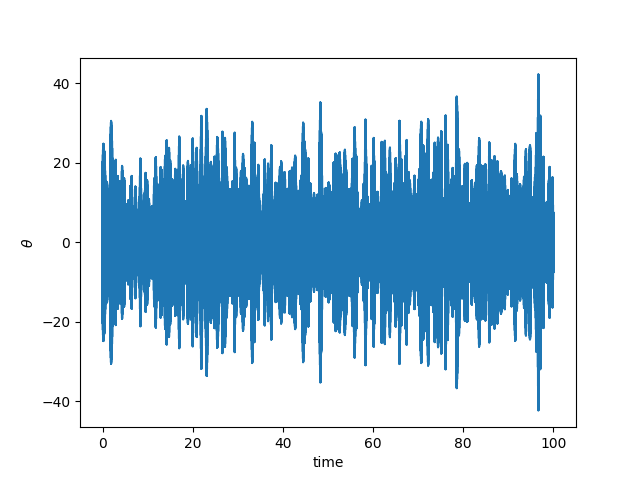

In [227]:
thetas = get_theta()
ts = np.arange(len(thetas)) / sample_freq

fig, ax = plt.subplots()
ax.plot(ts, thetas)
ax.set_xlabel("time")
ax.set_ylabel("$\\theta$")
plt.show()

## PSD of powers of theta

Power at low frequencies with even orders of power in theta.

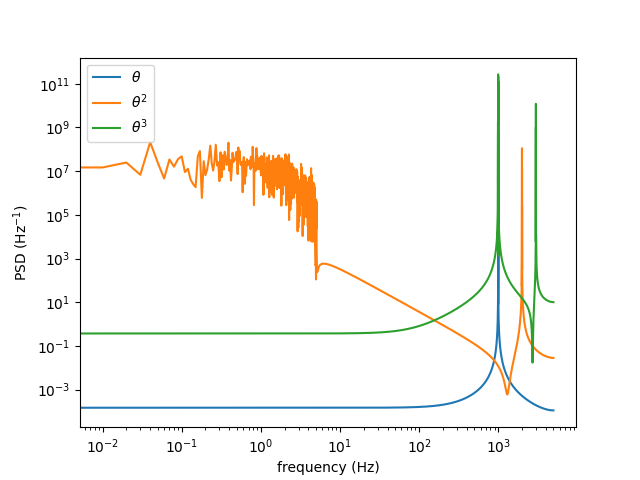

In [228]:
fs, psd_theta = get_psd(thetas, sample_time)
thetas_sq = thetas ** 2
fs, psd_theta_sq = get_psd(thetas_sq, sample_time)
thetas_cu = thetas ** 3
fs, psd_theta_cu = get_psd(thetas_cu, sample_time)
fig, ax = plt.subplots()
ax.plot(fs, psd_theta, label="$\\theta$")
ax.plot(fs, psd_theta_sq, label="$\\theta^2$")
ax.plot(fs, psd_theta_cu, label="$\\theta^3$")
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("PSD (Hz$^{-1}$)")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()

## Apply a low-pass filter on the data (experiment cycle frequency << axion mass)

For a detector linear to theta, most of the high-frequency ALP field amplitude fluctuations around the axion mass frequency averaged out. However, the amplitude fluctuations are not averaged out in a quadratic detector.

There is some residual power at low frequencies in the linear detector though. The residual power is due to the finite quality factor of the Axion field - the amplitude fluctuation is only suppressed by a factor of Q.
Therefore, if we are looking at the PSD of the squared data of a slow linear detector, the PSD is suppressed by a factor of Q^4 compared to the PSD of a slow quadratic detector.

In [229]:
def average(array, N):
    """Average the data by every N points."""
    N = int(N)
    return np.mean(array[:(len(array) // N) * N].reshape(-1, N), axis=1)

In [230]:
coherence_time = Q_factor / freq
average_N = coherence_time * sample_freq / 10  # sample time is 10x shorter than the coherence time.

ts_downsample = average(ts, average_N)
thetas_sq_downsample = average(thetas_sq, average_N)  # a quadratic detector
thetas_downsample = average(thetas, average_N)
thetas_downsample_sq = thetas_downsample ** 2  # a linear detector squared

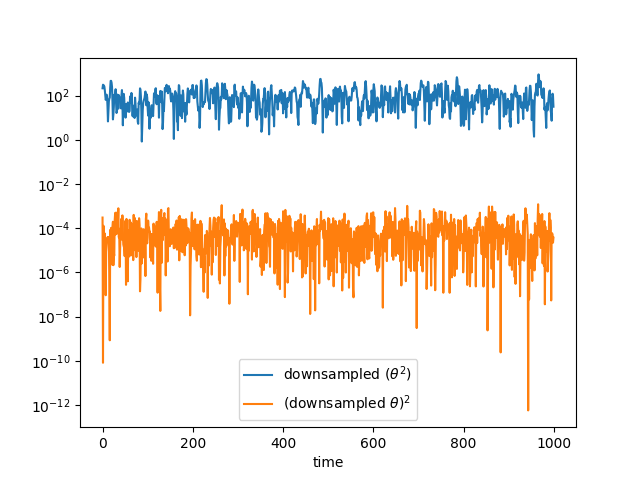

In [231]:
fig, ax = plt.subplots()
ax.plot(thetas_sq_downsample, label="downsampled ($\\theta^2$)")
ax.plot(thetas_downsample_sq, label="(downsampled $\\theta$)$^2$")
ax.set_yscale("log")
ax.set_xlabel("time")
ax.legend()
plt.show()

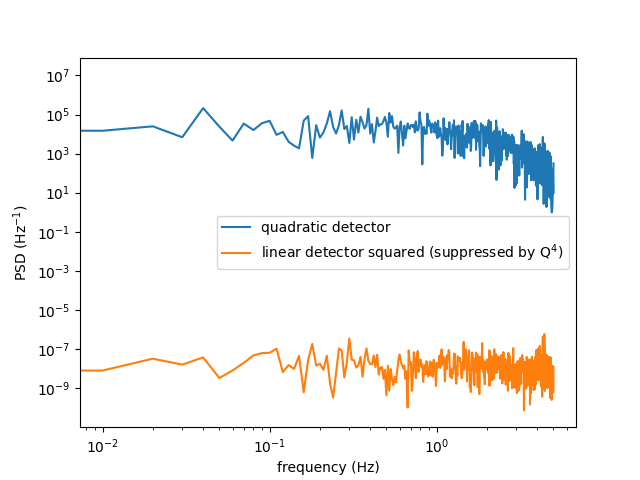

In [232]:
fs_downsample, psd_theta_sq_downsample = get_psd(thetas_sq_downsample, ts_downsample[1] - ts_downsample[0])
fs_downsample, psd_theta_downsample_sq = get_psd(thetas_downsample_sq, ts_downsample[1] - ts_downsample[0])

fig, ax = plt.subplots()
ax.plot(fs_downsample, psd_theta_sq_downsample, label="quadratic detector")
ax.plot(fs_downsample, psd_theta_downsample_sq, label="linear detector squared (suppressed by Q$^4$)")
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("PSD (Hz$^{-1}$)")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()